In [23]:
import os
import sys
import math
import argparse
import logging
import json
from operator import itemgetter
sys.path.append("/home/s3/hyeryung/mucoco")
os.chdir("/home/s3/hyeryung/mucoco")

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from numpy import std
from tqdm import tqdm
import torch
import pandas as pd
import wandb
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import get_linear_schedule_with_warmup, AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW
import torch.nn as nn

from notebooks.utils.load_ckpt import define_model

In [6]:
device = 'cuda'
model, tokenizer = define_model(num_classes=1, device=device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
S

DEVICE:  cuda


In [3]:
data = pd.read_json('../data/yelp_academic_dataset_review.json', nrows=100000, lines=True)

<Axes: >

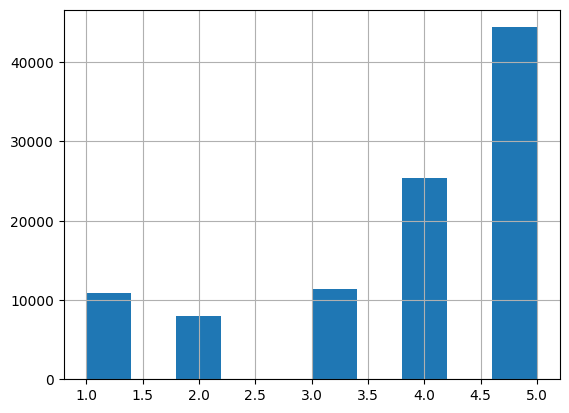

In [5]:
## review - label 간에 quality 문제가 있는지 확인
## review의 길이에 문제가 있는지 확인
data.stars.hist()

## review - label 간에 quality 문제가 있는지 확인

없다.

In [58]:
def display_row(myrow):
    print(f"---- {myrow['stars'].index.values[0]}: {myrow['stars'].values[0]} (seq_length: {myrow['seq_length'].values[0]}) ----")
    print(myrow['text'].values[0])

In [59]:
row = data.loc[data['stars']==5,:].sample(1)
display_row(row)

---- 75466: 5 (seq_length: 65) ----
We love this little restaurant.  The food is always fresh and creative.  The owner and staff are always very pleasant and welcoming.  The dining area is cozy and clean.  We like to think of State Street Kitchen as "our secret spot", but we love to tell people our secret.  Love this place!


In [60]:
row = data.loc[data['stars']==4,:].sample(1)
display_row(row)

---- 47649: 4 (seq_length: 154) ----
I really enjoyed Sophie's Nails! I think its a great little place on the south side that is extremely affordable and they do a great job! I got my toes done before I left for San Fran and they painted them bright pink! The nail polish has lasted without a chip or dent. They were quick to do the pedicure and they did a really good job. I also enjoyed the massage chairs they had, I probably could have sat in them all day! They also managed to squeeze me in for an eyebrow waxing at the last minute and both spa treatments ended up costing me $45 with tax and tip. A great del if you ask me! They also offer gel schalack nails, which I'm hoping to try in the near future!


In [61]:
row = data.loc[data['stars']==3,:].sample(1)
display_row(row)

---- 82079: 3 (seq_length: 226) ----
I have been intrigued by this place for a while,  and I had the opportunity to try it tonight. 

It is an all-you-can-eat for one price for format. They have a wide variety of items, and just as you might expect, when you're a jack-of-all-trades you're a master of none.

There were not many people when I came, as I arrived early, and the waitress was attentive, and overly so, as she demanded my order and my follow-up orders rapidly, without giving me time to digest my thoughts or my food.

The sushi was fair, the rice was soggy and a little bit cool, and it didn't really have enough of the sushi Su in it, but the fish involved was plentiful, if not the best.

The non sushi Asian food was also lackluster, more diner or take out quality, and really not that entertaining.  

If you want to eat, this is the place to eat. If you want to savor this is not the place for you.


In [62]:
row = data.loc[data['stars']==2,:].sample(1)
display_row(row)

---- 4646: 2 (seq_length: 226) ----
You know when you go to place, have an ok meal and then you forget it exists? That is Ants Pants Cafe: forgetable. 

I don't know why I forgot Ants Pants the first time. I think I enjoyed my food and the service was fine. I think it was that Ants Pants was merely unexceptional. 

Today, a friend suggested Ants Pants. I thought, "Oh yeah. That place." We wandered over from my job and had a very late brunch. I had two eggs and my friend had a salad. Both plates were good, but nothing struck a chord. There should be something you tell your friends with relish or with venom. There should be something that sticks out about a place. The atmosphere at Ants Pants wreaks of BLAH. 

I can say that whoever designed Ants Pants is a genius of spatial planning. For a place so small , they smanage to fit 24 seats well enough. But should seating charts spring to mind for where you go for brunch? 

No. Very Blah.


In [63]:
row = data.loc[data['stars']==1,:].sample(1)
display_row(row)

---- 94651: 1 (seq_length: 249) ----
I've lived at the Summit for two years now, I resigned hoping after the management changed things would get better, but of course they didn't. It's really close to campus, but there's no parking at night, traffic is really bad, and it is extremely overpriced. The apartments look nice at a glance but were built very badly and have a lot of technical issues like leaks and broken appliances. If you want a quiet place to live, this is not the place to be, students are constantly partying, running around yelling, throwing up everywhere, and setting off the entire building's fire alarms. The alarms go one for at least a half an hour and a lot of times its really late at night, the alarm is actually going off right now and that why I'm writing this review. Where every you decided to live, DO NOT choose the Summit, it might look pretty with pool, hot tub, and granite counter tops, but you'll regret it. I would just find a house near by for rent or if you re

## review의 길이에 문제가 있는지 확인

slight negative correlation between data['stars'] and data['seq_length']

In [7]:
data['text_tokens'] = data['text'].apply(lambda x: tokenizer.tokenize(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors


In [9]:
data['seq_length'] = data['text_tokens'].apply(len)

<Axes: >

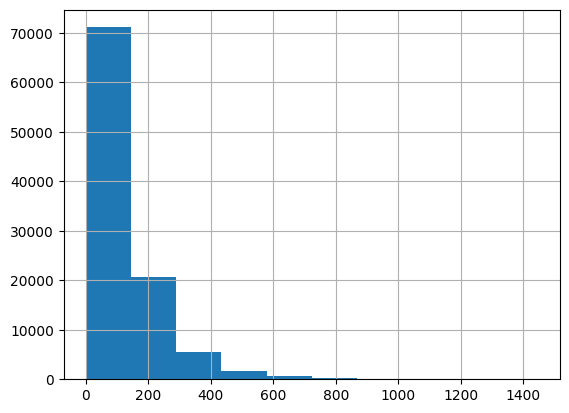

In [11]:
data.seq_length.hist()

In [14]:
data.text[10]

"My experience with Shalimar was nothing but wonderful. \nI wanted to get my engagement ring sized and was told over the phone that it could probably be done within the day. \nWhen I brought it by, the team confirmed that the jeweler would be able to accommodate my same-day request and that it would be around $40 (simple band, decrease by three full sizes).\nI checked my size one more time, confirmed, and left to let them do their thing.\nWhen I came to pick up later that afternoon, the ring was too small. It's very important to note that Shalimar sized the ring perfectly, but that I made a mistake and should've gone up a half-size.\nThe Shalimar group were completely understanding and accommodating, even resizing my ring back up and getting it back to me within an hour at no charge! Even though it was my mistake!\nThe associates' attitudes in dealing with what was a pretty embarrassing situation instantly earned my satisfaction and loyalty as a customer. Very grateful for such a wonde

In [15]:
data.seq_length[10]

216

In [17]:
data.loc[data['seq_length']>512,'text'][200]

"Too big, too expensive and too far from Downtown.  \n\nI was here for a conference, which seemed like an awesome idea. It wasn't.  I'm in Direct Sales and (like most people at this conference) don't have tons of extra money to spend on mediocre meals when I'm traveling.  $10 for a slice of generic pizza, small side salad and a soda for lunch.   I understand it's a hotel but there weren't any options close by.  Just getting your car from valet was a hassle and took a lot of time.  Being such a big property, it made getting to restaurants off the property really time intensive.  Since you're so far out of Nashville (out near the airport), the good little holes you find when you're in a city are pretty nonexistent.  \n\nThe property itself was great.  The hotel is HUGE but really pretty.  I enjoyed walking around but was really happy when I found what I didn't know existed...a shortcut between my room and the Convention Center.  It took my 10-15 minute walk down to about 3 minutes!  BONU

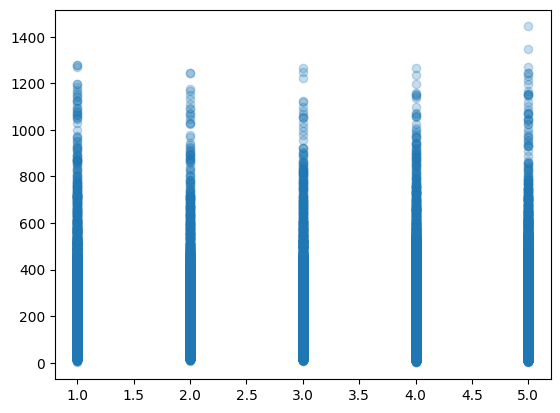

In [22]:
plt.scatter(data['stars'], data['seq_length'], alpha=0.25) ## seemingly no correlation between data['stars'] and data['seq_length']

In [24]:
pearsonr(data['stars'], data['seq_length']) ## slight negative correlation between data['stars'] and data['seq_length']

PearsonRResult(statistic=-0.1657030481495406, pvalue=0.0)

<Axes: >

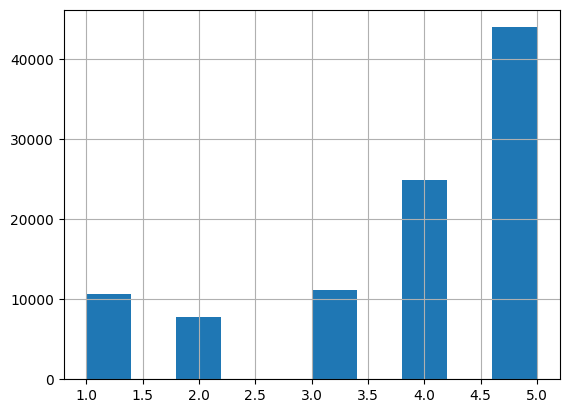

In [27]:
data.loc[data['seq_length']<=512,'stars'].hist()

In [66]:
pearsonr(data.loc[data['seq_length']<=512,'stars'], data.loc[data['seq_length']<=512,'seq_length']) ## slight negative correlation between data['stars'] and data['seq_length']

PearsonRResult(statistic=-0.1671715581890735, pvalue=0.0)

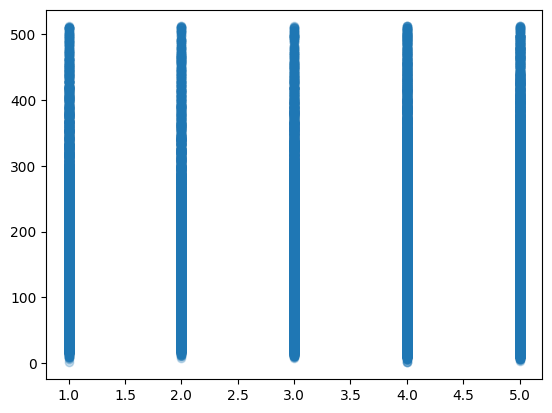

In [29]:
plt.scatter(data.loc[data['seq_length']<=512,'stars'], data.loc[data['seq_length']<=512,'seq_length'], alpha=0.25) 

<Axes: >

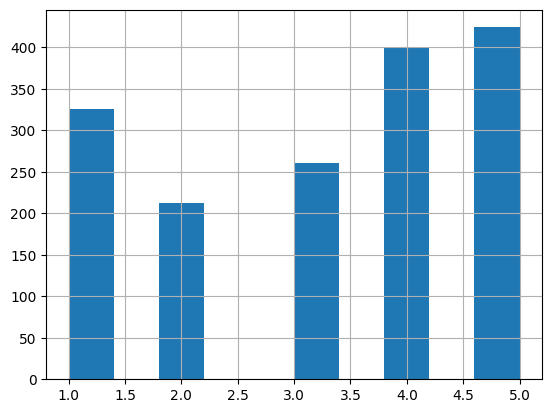

In [28]:
data.loc[data['seq_length']>512,'stars'].hist()